# Netflix EDA | CPSC 222, Spring 2022 | Matt Nguyen

___
## Introduction

For this project, I will be examining my Netflix watch data from November 11th, 2017 to April 18th 2022. Albeit this is 5 years of data, I only began watching Netflix consistently during 2020, right after COVID-19 caused initial shutdowns.  

This data is in **CSV** format and has **541 instances** on **8 attributes**: Title, Date Viewed, Year Released, Genres, Keywords,Duration, Type, Maturity Rating.

I downloaded the data directly from [Netflix](https://help.netflix.com/en/node/101917). It initially had the Title and Date Attributes, with the rest being added manually. To make this project more interesting, I decided to merge a days of week dataset generated from excel, which provided me the day of week for each instance in my netflix data.  

Netflix data is important and interesting to me because throughout the pandemic watching Netflix gave me something enjoyable to do/look forward to, and so, I'd like to further explore the numbers behind my watching during that time , and see if I can create something unique which presents that in a clear, concise way. 

* What are you trying to classify in the dataset
* What are potential impacts of the results
* Who are stakeholders interested in your results

___

## Importing Libraries
* to start, we will import all needed libraries for this project
* also importing a final_utils file for utility functions

In [173]:
%%capture
from importlib import reload
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import final_utils as utils
reload(utils)


---
## Data Analysis

### Loading & Cleaning the Data

Utilizing the pandas library, I will be loading the data into two separate dataframes. 

### Cleaning
For cleaning, I will be dropping duplicates on the days of week dataset and merging it on the "Date Viewed" attribute with the Netflix data. Next, I will be cleaning the "Title" column by removing the season & episode number. I noticed the format of all titles was "Title: Season: Episode" so I decided to split the titles at the ":" character, and then replacing them with what came before. For one series, "Avatar: The Last Airbender" removing the title after the ":" would cause ambiguity, so I wrote a special case in the function to account for that. Lastly, I outputted the merged and cleaned dataset to csv. 

### Challenges? 
I had limited challenges with this portion of the project, but it did take a significant amount of time to manually add columns into the netflix dataframe. Further, I also experience trouble merging the two dataframe until I realized I needed to drop duplicates in the days of week dataset to successfully merge.  

In [174]:
# loading
netflix_df = utils.load_data("NetflixData.csv")
days_df = utils.load_data("days_of_week.csv")
days_df = days_df.drop_duplicates()

# merging 
netflix_merged_df = netflix_df.merge(days_df, on="Date Viewed")

# cleaning
title_col_ser = netflix_merged_df["Title"]
cleaned_title_col_ser = title_col_ser.copy()
netflix_merged_df["Title"] = utils.clean_titles(title_col_ser, cleaned_title_col_ser)

# to csv
netflix_merged_df.to_csv("NetflixMerged.csv", index=False)

### Aggregation
For this section, I am going to be grabbing some numeric columns within the data and computing basic statistics, such as, mean, sum, mode. Further, I will also be using the groupby method to find the ratio between TV Series, movies, documentary's, etc. that I watched in the past five years. 


In [175]:
# getting series to compute stats on
duration_col_ser = netflix_merged_df["Duration"]
release_col_ser = netflix_merged_df["Year Released"]

## duration stats
stats = utils.compute_stats(duration_col_ser)
mean_duration = stats[0]
total_mins_watched = stats[1]
frequent_duration = stats[2]

# release yr stats
stats = utils.compute_stats(release_col_ser)
avg_release_yr = stats[0]
frequent_release_yr = stats[2]

# total number watched
num_watched = len(netflix_merged_df)

# ratio stats
utils.type_stats(netflix_merged_df, "Type")

# trying to get the total minutes watched for each title, can't quite figure it out
# title_groupby = netflix_merged_df.groupby(['Title', 'Duration'])
# title_df = pd.DataFrame(title)

utils.build_stats_ser(mean_duration, total_mins_watched, frequent_duration, num_watched, frequent_release_yr, avg_release_yr)

              Type
Type              
Documentary  0.004
Docuseries   0.015
Movie        0.011
TV Series    0.970

Average Duration                 26.10536
Total Minutes Watched         14123.00000
Most Frequent Duration           23.00000
Number Watched                  541.00000
Most Frequent Release Year     2015.00000
Average Release Year           2012.74100
dtype: float64

              Type
Type              
Documentary  0.004
Docuseries   0.015
Movie        0.011
TV Series    0.970


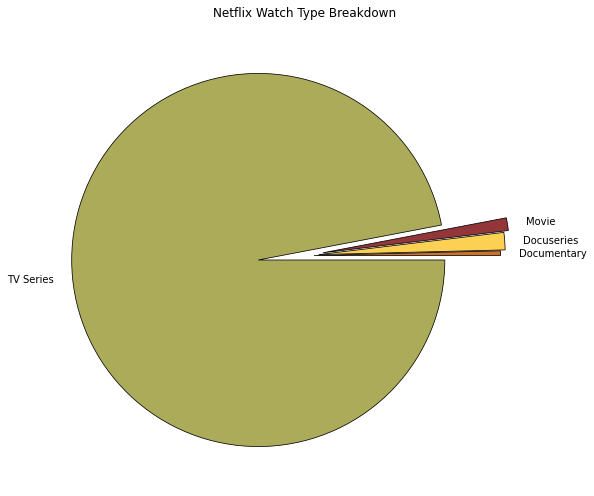

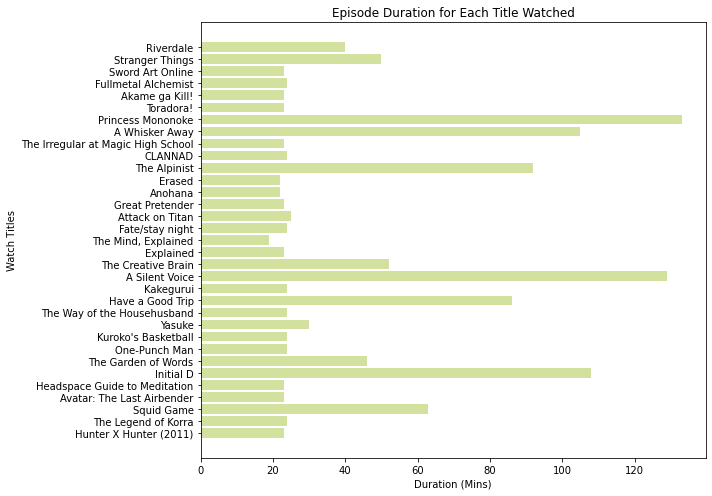

In [176]:
## Visualizations

# Type Pie Chart

colors = ("#cd722d", "#fcd053", "#933639","#abab5a")
wp = { 'linewidth' : 0.75, 'edgecolor' : "black" }
explode = (0.05, 0.075, 0.1, 0.25)

plt.figure(figsize =(10, 7))
plt.pie(ratio_df["Type"], labels = ratio_df.index, colors=colors, wedgeprops=wp, explode=explode)
plt.title("Netflix Watch Type Breakdown")
plt.tight_layout()
plt.show()

# Bar Chart
plt.figure(figsize =(10, 7))
plt.barh(cleaned_title_col_ser, netflix_merged_df["Duration"], color='#D3E19F')
plt.xlabel("Duration (Mins)")
plt.ylabel("Watch Titles")
plt.title("Episode Duration for Each Title Watched")
plt.tight_layout()
plt.show()


### Hypothesis Testing
* Looking at 2020 (the time in which I watched the most Netlix), one thing I'd like to examine is if how the summer months affected my watch time per day. Specifically, I'd like to look at how July-August potentially differed in view time to September-October. Just to be extra clear, I think my average viewing per day will be larger will be greater in the summer months than in the fall months due to not being in school at the time. 

#### Getting the necessary data

In [177]:
summer_df = netflix_merged_df.loc[264:322]
fall_df = netflix_merged_df.loc[200:258]

summer_group_df = summer_df.groupby(['Date Viewed'], as_index=False)['Duration'].sum()
fall_group_df  = fall_df.groupby(['Date Viewed'], as_index=False)['Duration'].sum()

# PRINT TESTING...
# print(summer_group_df["Duration"].sum())
# print(len(summer_group_df))

# print(fall_group_df["Duration"].sum())
# print(len(fall_group_df))

# print(len(fall_group_df) + len(summer_group_df))

Let "S" represent summer months & "F" represent fall months

1. $H_{0} : \mu_{S} = \mu_{F}$  
   $H_{1} : \mu_{S} > \mu_{F}$
2. $\alpha = 0.05$
3. Independent two-sample, one-tailed t-test
4. $t = 1.697$ (significance level of 0.05, 34 degrees of freedom, using 30 ) 
    * If $t > 1.697$, reject $H_{0}$
    * If $t < 1.697$, fail to reject $H_{0}$
5. Calculations are below: 

In [178]:
t_computed, p_value = stats.ttest_ind(summer_group_df["Duration"], fall_group_df["Duration"])
print("t-computed:", t_computed, "\np-value:", p_value/2)

AttributeError: 'tuple' object has no attribute 'ttest_ind'